# Importing Necessary Libraries

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score

# Loading Dataset

In [57]:
# Loading training and test datasets into Pandas DataFrames for further analysis and modeling
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Checking columns and their datatypes

In [58]:
# Displaying a concise summary of the DataFrame, including data types
print("Info of train.csv: ")
train_df.info()
print("Info of train.csv: "+"\n")
test_df.info()


Info of train.csv: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59611 entries, 0 to 59610
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   response_id               59611 non-null  int64  
 1   age                       59611 non-null  int64  
 2   gender                    59611 non-null  object 
 3   years_at_company          59611 non-null  int64  
 4   job_role                  59611 non-null  object 
 5   monthly_income            57811 non-null  float64
 6   work_life_balance         49467 non-null  object 
 7   job_satisfaction          52447 non-null  object 
 8   performance_rating        59611 non-null  object 
 9   promotions_count          59611 non-null  int64  
 10  overtime                  59611 non-null  object 
 11  distance_from_home        59611 non-null  int64  
 12  education_level           59611 non-null  object 
 13  marital_status            59611 non-null 

In [59]:
# Displaying total missing values in each column
print("Total missing values per column in train.csv :")
print(train_df.isnull().sum(),"\n")
print("Total missing values per column in test.csv :")
print(test_df.isnull().sum())


Total missing values per column in train.csv :
response_id                     0
age                             0
gender                          0
years_at_company                0
job_role                        0
monthly_income               1800
work_life_balance           10144
job_satisfaction             7164
performance_rating              0
promotions_count                0
overtime                        0
distance_from_home              0
education_level                 0
marital_status                  0
dependents_count             4780
job_level                       0
company_size                 2992
company_tenure               4184
remote_work                     0
leadership_opportunities        0
innovation_opportunities        0
company_reputation              0
employee_recognition            0
exit_status                     0
dtype: int64 

Total missing values per column in test.csv :
response_id                    0
age                            0
gender    

# Handling Missing Values

In [60]:
# Defining numerical columns to fill missing values with the median
numerical_cols = ['monthly_income', 'dependents_count', 'company_tenure']
for col in numerical_cols:
    train_df[col] = train_df[col].fillna(train_df[col].median())
    test_df[col] = test_df[col].fillna(test_df[col].median())

# Defining categorical columns to fill missing values with the mode
categorical_cols = [
    'work_life_balance', 'job_satisfaction', 'company_size', 'gender', 'job_role',
    'marital_status', 'performance_rating', 'overtime', 'education_level', 'job_level',
    'remote_work', 'leadership_opportunities', 'innovation_opportunities',
    'company_reputation', 'employee_recognition'
]
for col in categorical_cols:
    train_df[col] = train_df[col].fillna(train_df[col].mode()[0])
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])


# Exploratory Data Analysis(EDA)

Missing values per column:
response_id                 0
age                         0
gender                      0
years_at_company            0
job_role                    0
monthly_income              0
work_life_balance           0
job_satisfaction            0
performance_rating          0
promotions_count            0
overtime                    0
distance_from_home          0
education_level             0
marital_status              0
dependents_count            0
job_level                   0
company_size                0
company_tenure              0
remote_work                 0
leadership_opportunities    0
innovation_opportunities    0
company_reputation          0
employee_recognition        0
exit_status                 0
dtype: int64


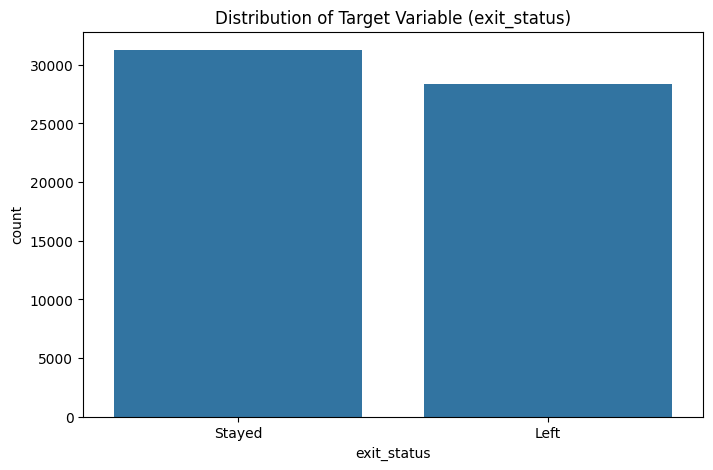

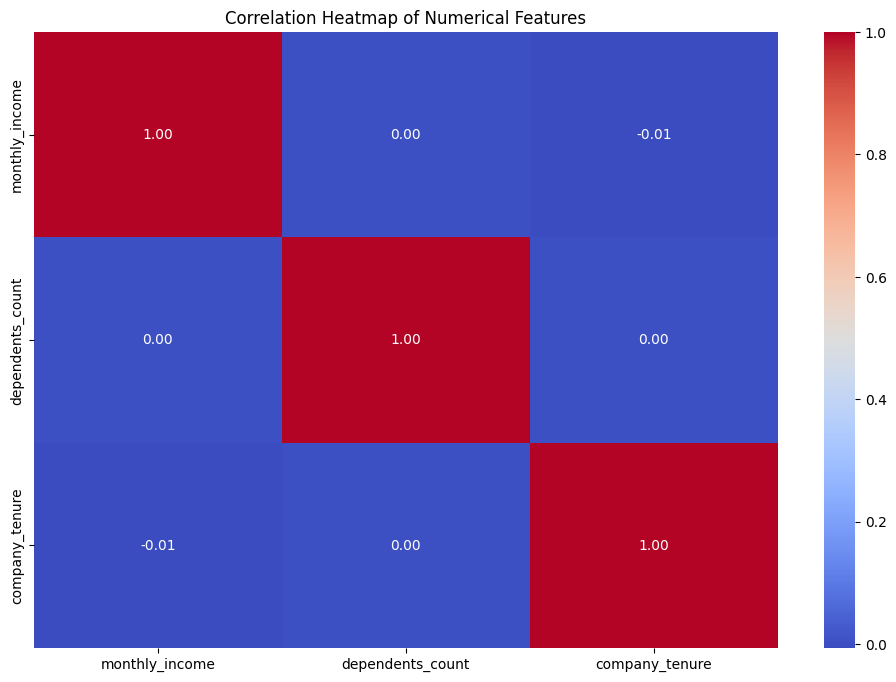

In [61]:
# Visualizing missing values to ensure no gaps remain
missing_values = train_df.isnull().sum()
print("Missing values per column:")
print(missing_values)

# Visualizing the distribution of the target variable to detect class imbalance
plt.figure(figsize=(8, 5))
sns.countplot(x='exit_status', data=train_df)
plt.title("Distribution of Target Variable (exit_status)")
plt.show()

# Visualizing correlations among numerical features with a heatmap for better feature selection insights
plt.figure(figsize=(12, 8))
sns.heatmap(train_df[numerical_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


# Feature Engineering

In [62]:
# Creating new features based on domain knowledge
train_df['years_at_company'] = train_df['company_tenure']
train_df['family_size'] = train_df['dependents_count'] + train_df['marital_status'].map({'Single': 1, 'Married': 2, 'Divorced': 1})

test_df['years_at_company'] = test_df['company_tenure']
test_df['family_size'] = test_df['dependents_count'] + test_df['marital_status'].map({'Single': 1, 'Married': 2, 'Divorced': 1})


# Data Preparation

In [63]:
# Splitting features and target variable from the training data
X = train_df.drop(columns=['exit_status', 'response_id'])
y = train_df['exit_status']

# Dropping the ID column from the test data
X_test = test_df.drop(columns=['response_id'])

# Performing under-sampling to balance the target classes
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Scaling numerical features to normalize values
scaler = MinMaxScaler()
X_resampled[numerical_cols] = scaler.fit_transform(X_resampled[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Encoding the target variable into numeric format
label_encoder = LabelEncoder()
y_resampled_encoded = label_encoder.fit_transform(y_resampled)


# Hyperparameter Tuning with Cross-Validation

In [ ]:
!pip install catboost #Im using Catboost
from catboost import CatBoostClassifier

In [65]:
# Defining a parameter grid for RandomizedSearchCV
param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6],
    'l2_leaf_reg': [1, 3]
}

# Identifying categorical feature indices for CatBoost
cat_features_indices = [X.columns.get_loc(col) for col in categorical_cols]

# Initializing the CatBoostClassifier
catboost_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='F1',
    random_seed=42,
    cat_features=cat_features_indices
)

# Running RandomizedSearchCV for hyperparameter optimization
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_grid,
    n_iter=5,  # Number of random parameter combinations
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Fitting RandomizedSearchCV to the resampled training data
random_search.fit(X_resampled, y_resampled_encoded)

# Saving and displaying the best hyperparameters
best_params = random_search.best_params_
print("Best parameters found:", best_params)
print("Best F1 Score from tuning:", random_search.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
0:	learn: 0.7091278	total: 92.5ms	remaining: 18.4s
1:	learn: 0.7085230	total: 170ms	remaining: 16.8s
2:	learn: 0.7085452	total: 221ms	remaining: 14.5s
3:	learn: 0.7086601	total: 310ms	remaining: 15.2s
4:	learn: 0.7086601	total: 364ms	remaining: 14.2s
5:	learn: 0.7088965	total: 426ms	remaining: 13.8s
6:	learn: 0.7178318	total: 486ms	remaining: 13.4s
7:	learn: 0.7145134	total: 558ms	remaining: 13.4s
8:	learn: 0.7163064	total: 624ms	remaining: 13.2s
9:	learn: 0.7146977	total: 676ms	remaining: 12.8s
10:	learn: 0.7192593	total: 744ms	remaining: 12.8s
11:	learn: 0.7202006	total: 824ms	remaining: 12.9s
12:	learn: 0.7246911	total: 885ms	remaining: 12.7s
13:	learn: 0.7339400	total: 976ms	remaining: 13s
14:	learn: 0.7301886	total: 1.04s	remaining: 12.9s
15:	learn: 0.7354109	total: 1.12s	remaining: 12.9s
16:	learn: 0.7364175	total: 1.19s	remaining: 12.8s
17:	learn: 0.7375114	total: 1.26s	remaining: 12.7s
18:	learn: 0.7387742	total: 1.33s

# Training Final Model and Making Predictions

In [66]:
# Training the final model with the best hyperparameters
final_model = CatBoostClassifier(
    **best_params,
    cat_features=cat_features_indices,
    loss_function='Logloss',
    eval_metric='F1',
    random_seed=42
)
final_model.fit(X_resampled, y_resampled_encoded)

# Making predictions on the test set
y_test_pred = final_model.predict(X_test)

# Preparing the submission file with predictions
submission_df = pd.DataFrame({
    'response_id': test_df['response_id'],
    'exit_status': label_encoder.inverse_transform(y_test_pred.astype(int))
})
submission_df.to_csv('submission.csv', index=False)

# Displaying the first few rows of the submission file
print("Sample submission file:")
print(submission_df.head())


0:	learn: 0.7091278	total: 93.1ms	remaining: 18.5s
1:	learn: 0.7085230	total: 190ms	remaining: 18.8s
2:	learn: 0.7085452	total: 243ms	remaining: 15.9s
3:	learn: 0.7086601	total: 334ms	remaining: 16.4s
4:	learn: 0.7086601	total: 389ms	remaining: 15.2s
5:	learn: 0.7088965	total: 451ms	remaining: 14.6s
6:	learn: 0.7178318	total: 512ms	remaining: 14.1s
7:	learn: 0.7145134	total: 622ms	remaining: 14.9s
8:	learn: 0.7163064	total: 704ms	remaining: 14.9s
9:	learn: 0.7146977	total: 759ms	remaining: 14.4s
10:	learn: 0.7192593	total: 830ms	remaining: 14.3s
11:	learn: 0.7202006	total: 904ms	remaining: 14.2s
12:	learn: 0.7246911	total: 963ms	remaining: 13.8s
13:	learn: 0.7339400	total: 1.05s	remaining: 13.9s
14:	learn: 0.7301886	total: 1.11s	remaining: 13.7s
15:	learn: 0.7354109	total: 1.19s	remaining: 13.7s
16:	learn: 0.7364175	total: 1.27s	remaining: 13.7s
17:	learn: 0.7375114	total: 1.34s	remaining: 13.5s
18:	learn: 0.7387742	total: 1.42s	remaining: 13.5s
19:	learn: 0.7398388	total: 1.49s	remain

# EDA to do final analysis

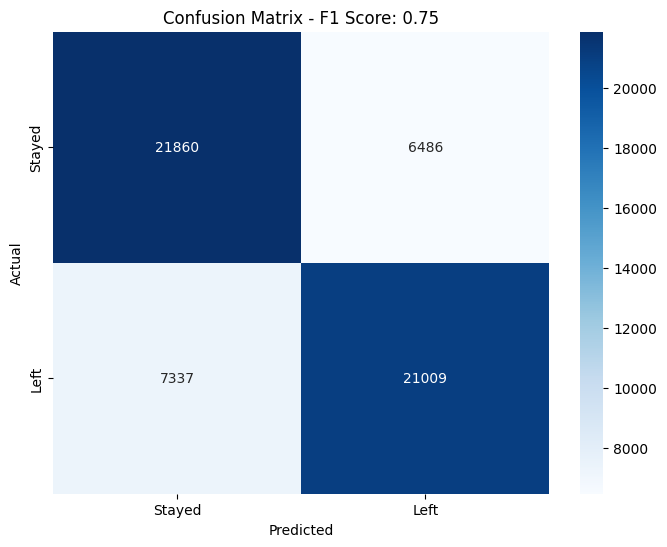

F1 Score: 0.75


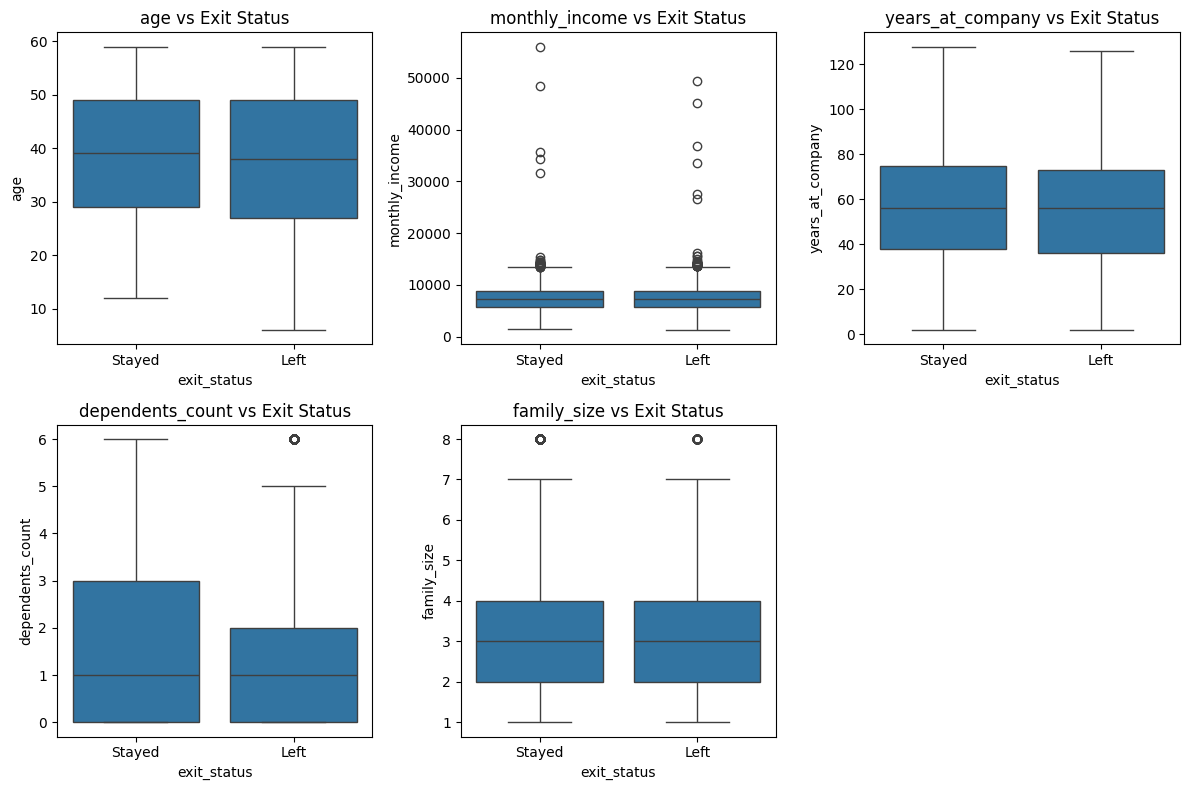

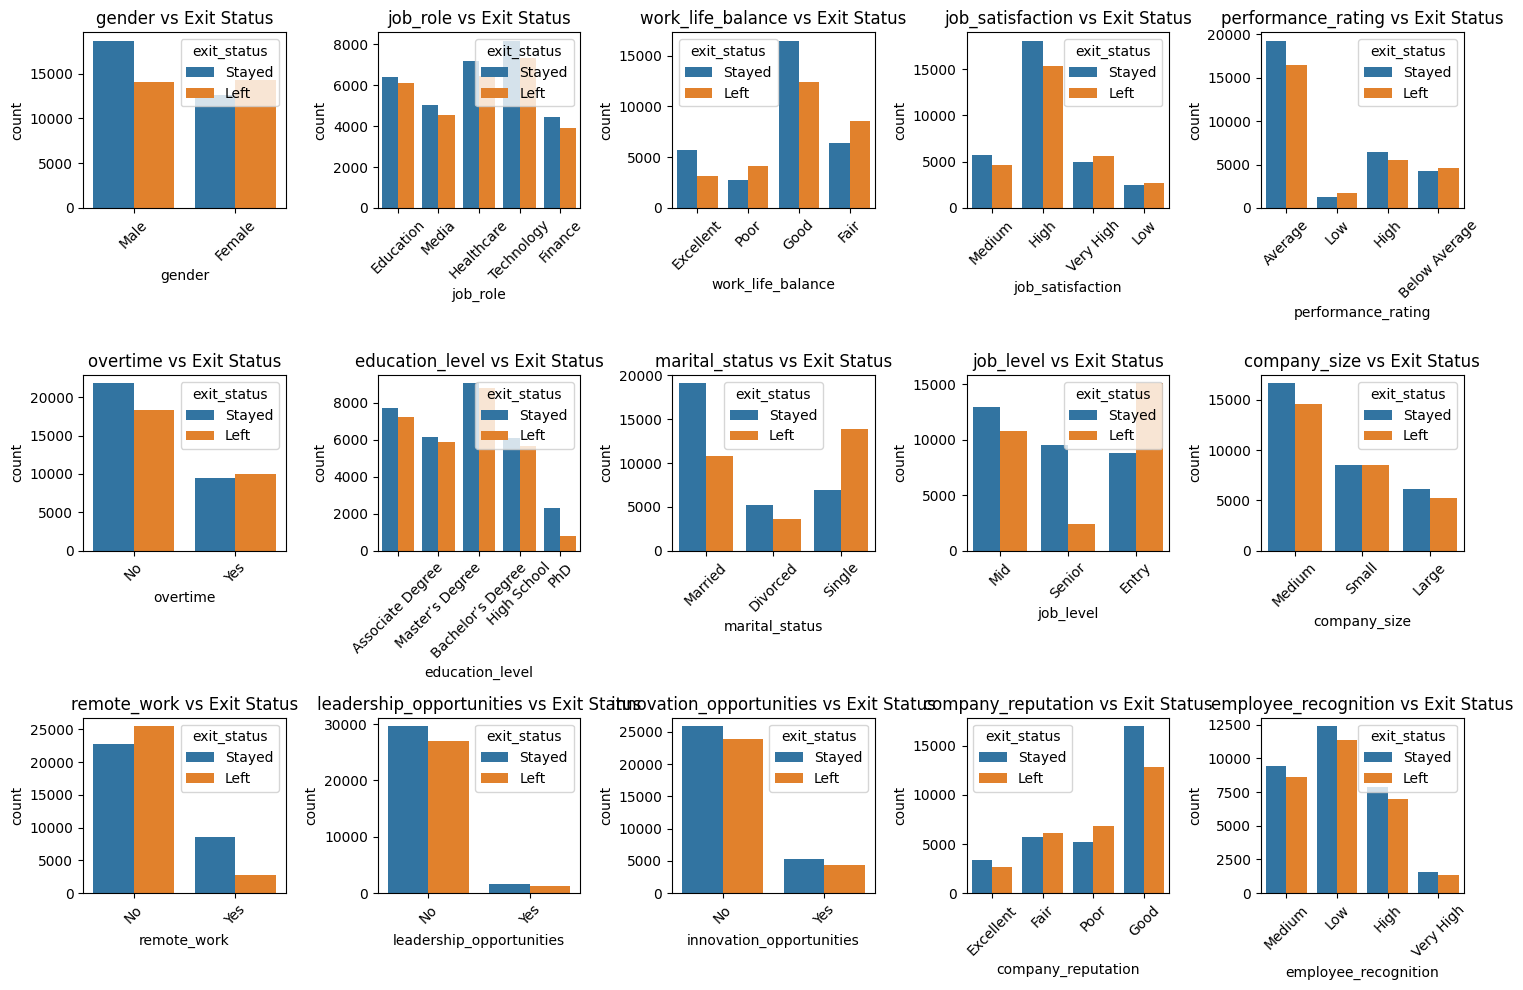

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

# 1. Computing the confusion matrix
# We are comparing the true labels (y_resampled_encoded) with the predicted labels from the final model.
cm = confusion_matrix(y_resampled_encoded, final_model.predict(X_resampled))  # y_true: actual values, y_pred: predicted values
f1 = f1_score(y_resampled_encoded, final_model.predict(X_resampled))  # We are calculating the F1 score to evaluate the model's performance

# 2. Visualizing the confusion matrix
# We are using a heatmap to display the confusion matrix for easy interpretation.
plt.figure(figsize=(8, 6))  # We are setting the figure size to 8x6 inches
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Stayed", "Left"], yticklabels=["Stayed", "Left"])
# 'annot=True' is adding the numeric values inside the heatmap cells.
# 'fmt="d"' is formatting the values as integers.
# 'cmap="Blues"' is applying a blue color scale to the heatmap for better visualization.
# 'xticklabels' and 'yticklabels' are labeling the axes with the categories ("Stayed" vs "Left").
plt.title(f"Confusion Matrix - F1 Score: {f1:.2f}")  # We are adding a title that shows the F1 score for easy reference
plt.ylabel('Actual')  # We are labeling the y-axis to indicate actual class labels
plt.xlabel('Predicted')  # We are labeling the x-axis to show predicted class labels
plt.show()  # We are displaying the confusion matrix plot

# Printing the F1 score to the console
print(f"F1 Score: {f1:.2f}")  # We are outputting the F1 score to evaluate the model's performance

# 3. Visualizing feature distributions against Exit Status (for Numerical Features)
# We are using boxplots to show the distribution of numerical features for each Exit Status category ("Stayed" or "Left").
numerical_cols = ['age', 'monthly_income', 'years_at_company', 'dependents_count', 'family_size']  # Example numerical columns

plt.figure(figsize=(12, 8))  # We are creating a figure with a size of 12x8 inches to allow for more space in visualizations
for i, feature in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)  # We are arranging the boxplots into a 2x3 grid to display all features in one plot
    sns.boxplot(x='exit_status', y=feature, data=train_df)
    # We are using the boxplot to compare the distribution of each numerical feature based on 'exit_status' (Stayed vs Left)
    plt.title(f'{feature} vs Exit Status')  # We are giving each plot a title for clarity
    plt.tight_layout()  # We are adjusting the layout to ensure the plots do not overlap
plt.show()  # We are displaying the boxplot visualizations
print("\n")

# 4. Visualizing feature distributions against Exit Status (for Categorical Features)
# We are using countplots to show the frequency distribution of categorical features based on Exit Status.
categorical_cols = ['gender', 'job_role', 'work_life_balance', 'job_satisfaction', 'performance_rating', 'overtime', 'education_level',
                    'marital_status', 'job_level', 'company_size', 'remote_work', 'leadership_opportunities', 'innovation_opportunities',
                    'company_reputation', 'employee_recognition']  # Example categorical columns

plt.figure(figsize=(15, 10))  # We are creating a larger figure with a size of 15x10 inches to accommodate all plots
for i, feature in enumerate(categorical_cols, 1):
    plt.subplot(3, 5, i)  # We are organizing the categorical features in a 3x5 grid layout
    sns.countplot(x=feature, hue='exit_status', data=train_df)
    # We are using the countplot to show the number of occurrences of each category based on 'exit_status' (Stayed vs Left)
    plt.title(f'{feature} vs Exit Status')  # We are giving each plot a title for clarity
    plt.xticks(rotation=45)  # We are rotating the x-axis labels by 45 degrees to prevent overlap and ensure readability
    plt.tight_layout()  # We are ensuring the layout is tight to avoid any overlapping of elements
plt.show()  # We are displaying the countplot visualizations
